In [68]:
import os
import urllib
import joblib
import tarfile
import numpy as np
from scipy import stats
from scipy.stats import randint
from zlib import crc32
import pandas as pd
from pandas.plotting import scatter_matrix
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

#Uses Jupyter's own backend to plot
%matplotlib inline

#To plot pretty figures
mpl.rc("axes", labelsize=14)
mpl.rc("xtick", labelsize=12)
mpl.rc("ytick", labelsize=12)

#Path for saving images 
IMAGES_PATH = os.path.join("images")
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Section: Get The Data

In [2]:
DOWNLOAD_ROOT = "http://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

#### Extract CSV file from TGZ file

In [3]:
def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    os.makedirs(housing_path, exist_ok=True)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

In [4]:
fetch_housing_data()

In [5]:
def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

In [6]:
housing = load_housing_data()

### Overview of the data - Data Structures

In [7]:
#First and last 10 cases
housing.head(10)
housing.head(-10)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY
...,...,...,...,...,...,...,...,...,...,...
20625,-121.52,39.12,37.0,102.0,17.0,29.0,14.0,4.1250,72000.0,INLAND
20626,-121.43,39.18,36.0,1124.0,184.0,504.0,171.0,2.1667,93800.0,INLAND
20627,-121.32,39.13,5.0,358.0,65.0,169.0,59.0,3.0000,162500.0,INLAND
20628,-121.48,39.10,19.0,2043.0,421.0,1018.0,390.0,2.5952,92400.0,INLAND


In [8]:
#Discription of data: # of row, attribute type and non-null values 
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [9]:
#Examine the categories of attribute type -> object (housing["ocean_proximity"])
housing["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [10]:
#Summary of numerical attributes
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


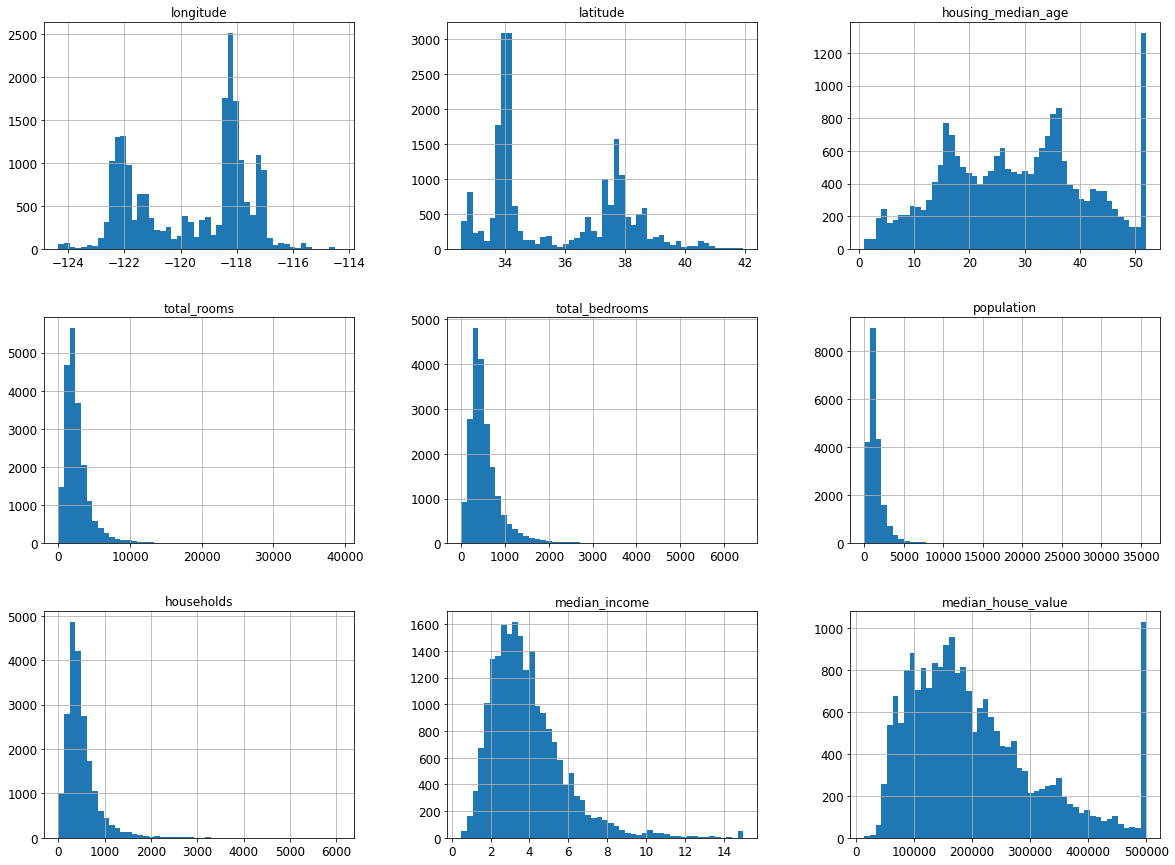

fig 2-8


In [11]:
#Make histograms to visualize the data
housing.hist(bins=50, figsize=(20,15))
plt.show()
print("fig 2-8")

### Create a test set

In [12]:
#Create a custom function to split the data into training/test sets (ratio:0.8/0.2)
#Option 1 - Unstable because the train/test sets will change we rerun the function
def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(test_ratio * len(data))
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]


In [13]:
train_set, test_set = split_train_test(housing, 0.2)
len(train_set), len(test_set) #Check if the ratios are correct

(16512, 4128)

In [14]:
#Option 2 - Stable if the dataset has an identifier column 
#(Not the case on this dataset(housing))
#Compute a hash for each identifier. If the hash is lower than 20% of the 
#max hash value -> test_set
def test_set_check(identifier, test_ratio):
    return crc32(np.int64(identifier)) & 0xffffffff < test_ratio*2**32

In [15]:
def split_train_test_by_id(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_:test_set_check(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]

In [16]:
#Option 3 - Most relevant for the housing dataset
#Use the the most stable features to build a unique identifier (latitude and longitude)
housing_with_id = housing.reset_index() #Adds "index" column
housing_with_id["id"] = housing["longitude"]*1000 + housing["latitude"]
train_set, test_set = split_train_test_by_id(housing_with_id, 
                                             0.2,
                                             "id")

In [17]:
#Option 4 - Use sklearn's train_test_split
train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

In [18]:
test_set.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
20046,-119.01,36.06,25.0,1505.0,NaN,1392.0,359.0,1.6812,47700.0,INLAND
3024,-119.46,35.14,30.0,2943.0,NaN,1565.0,584.0,2.5313,45800.0,INLAND
15663,-122.44,37.80,52.0,3830.0,NaN,1310.0,963.0,3.4801,500001.0,NEAR BAY
20484,-118.72,34.28,17.0,3051.0,NaN,1705.0,495.0,5.7376,218600.0,<1H OCEAN
9814,-121.93,36.62,34.0,2351.0,NaN,1063.0,428.0,3.7250,278000.0,NEAR OCEAN


### Up until now we used random sampling methods. It's ok if you have a large dataset. But if it isn't then there might be a sampling bias. The data needs to be represetative of the target you want to calculate (median income)

##### A closer examination of income category

figure 2-9


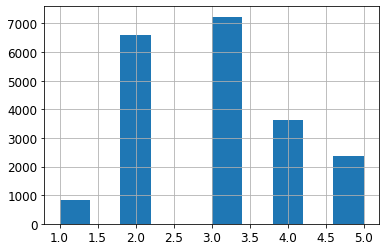

In [19]:
#We use stratified sampling to devide the median income into homogeneous 
#subgroups(strata)
housing["income_cat"] = pd.cut(housing["median_income"], 
                              bins = [0., 1.5, 3.0, 4.5, 6.0, np.inf], #Category range
                              labels = [1, 2, 3, 4, 5]) #Category label
housing["income_cat"].hist()
print("figure 2-9")

In [20]:
#Stratified sampling based on income_cat
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

##### Let's examine how the stratified and random test sets compare to the full dataset 

In [21]:
#Stratified sampling
strat_test_set["income_cat"].value_counts() / len(strat_test_set)

3    0.350533
2    0.318798
4    0.176357
5    0.114583
1    0.039729
Name: income_cat, dtype: float64

In [22]:
#Random sampling
housing["income_cat"].value_counts() / len(housing)

3    0.350581
2    0.318847
4    0.176308
5    0.114438
1    0.039826
Name: income_cat, dtype: float64

In [23]:
#Compare the two sampling methods to the full dataset 
def income_cat_proportions(data):
    return data["income_cat"].value_counts() / len(data)

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

#Make a new dataset to show the results 
compare_props = pd.DataFrame({
    "Overall": income_cat_proportions(housing),
    "Stratified": income_cat_proportions(strat_test_set),
    "Random": income_cat_proportions(test_set)
}).sort_index()
compare_props["Strat. %error"] = 100*compare_props["Stratified"] / compare_props["Overall"]-100
compare_props["Rand. %error"] = 100*compare_props["Random"] / compare_props["Overall"]-100

In [24]:
compare_props

,Overall,Stratified,Random,Strat. %error,Rand. %error
1,0.039826,0.039729,0.040213,-0.243309,0.973236
2,0.318847,0.318798,0.324370,-0.015195,1.732260
3,0.350581,0.350533,0.358527,-0.013820,2.266446
4,0.176308,0.176357,0.167393,0.027480,-5.056334
5,0.114438,0.114583,0.109496,0.127011,-4.318374


In [25]:
print("figure 2-10")

figure 2-10


##### From the chart above(figure 2-10), if we look at the %error, it's evident that the stratified sampling is almost identical with the full dataset, whereas the random sampling is skewed

##### Let's put the stratified data to it's original state by removing the "income_cat"

In [26]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

# End of section: Get The Data

# Section: Discover And Visualize The Data To Gain Insights

In [27]:
#Make a copy of the stratified training set
housing = strat_train_set.copy()

### Visualize the geographical data to get a better intuition

Figure 2-12


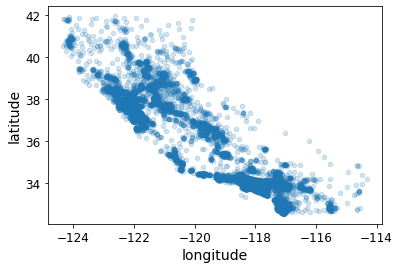

In [28]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.2)
print("Figure 2-12")

##### Visualize the housing prices

Figure 2-13


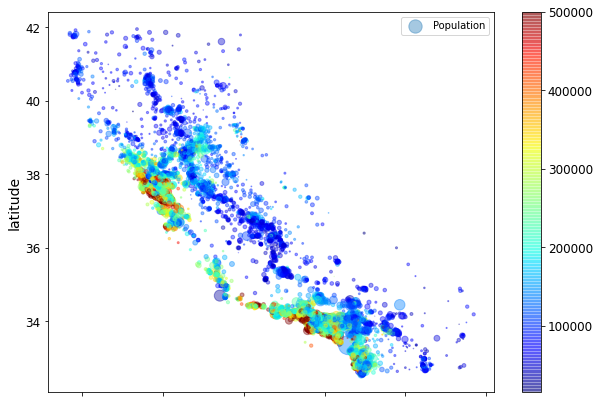

In [29]:
#In the plot bellow: s = district's population, c = price, 
#blue = low prices, red = high prices
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
            s=housing["population"]/100, label="Population", figsize=(10,7),
             c=housing["median_house_value"], cmap=plt.get_cmap("jet"), colorbar=True)
plt.legend()
print("Figure 2-13")

##### We can infer that the housing prices is primarily dictated by the location and population. A clustering algorithm might be helpful for detecting the main clusters and for adding new features that calculate the proximity to the cluster center

##### Additional: Make the figure look pretty

In [30]:
#Download California map
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
file_name = "california.png"
print("Downloading", file_name)
url = DOWNLOAD_ROOT + "images/end_to_end_project/" + file_name
urllib.request.urlretrieve(url, os.path.join(IMAGES_PATH, file_name))

('images\\california.png', <http.client.HTTPMessage at 0x15203027eb0>)

Saving figure California Housing Prices Plot
Figure 2-13


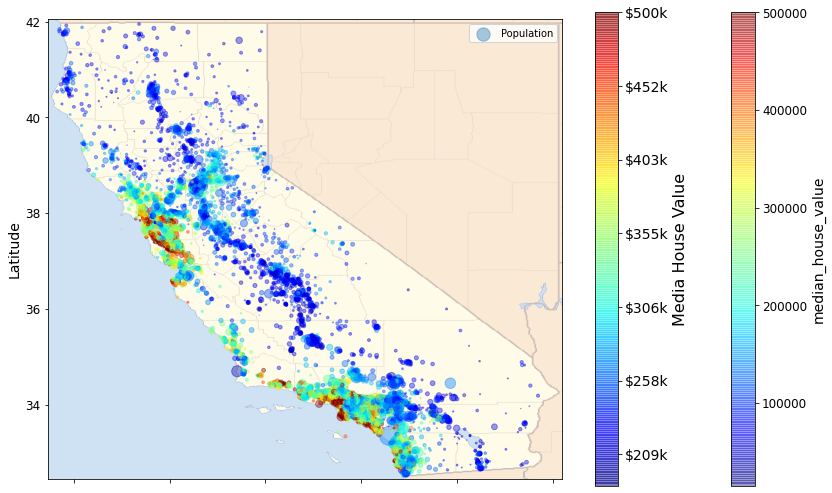

In [31]:
#Read image from folder
california_img = mpimg.imread(os.path.join(IMAGES_PATH, file_name))

#Make scatter plot
ax = housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4, figsize=(12,7),
                 s=housing["population"]/100, label="Population",
                 c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True)

#Add scatter plot on top of the image
plt.imshow(california_img, extent=[-124.55, -113.80, 32.45, 42.05], 
           alpha=0.5, cmap=plt.get_cmap("jet"))
plt.ylabel("Latitude", fontsize=14)
plt.xlabel("Longitude", fontsize=14)

prices = housing["median_house_value"]
tick_values = np.linspace(prices.min(), prices.max(), 11) 
cbar = plt.colorbar(ticks=tick_values/prices.max())
cbar.ax.set_yticklabels(["$%dk"%(round(v/1000)) for v in tick_values], fontsize=14)
cbar.set_label("Media House Value", fontsize=16)

plt.legend()
save_fig("California Housing Prices Plot")
plt.show

print("Figure 2-13")

### Looking for correlations

In [32]:
#The dataset isn't too large so we can compute the standard correlation 
#coefficient between every pair of attributes
#Note: It only measures linear correlation - if x goes up, y goes up/down
#and misses nonlinear correlation - if x is close to 0, then y generally goes up 

#Option #1 - corr() method
corr_matrix = housing.corr()

#Check how each attribute correlates to "median_house_value"
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

Saving figure Scatter Matrix Plot
Figure 2-15


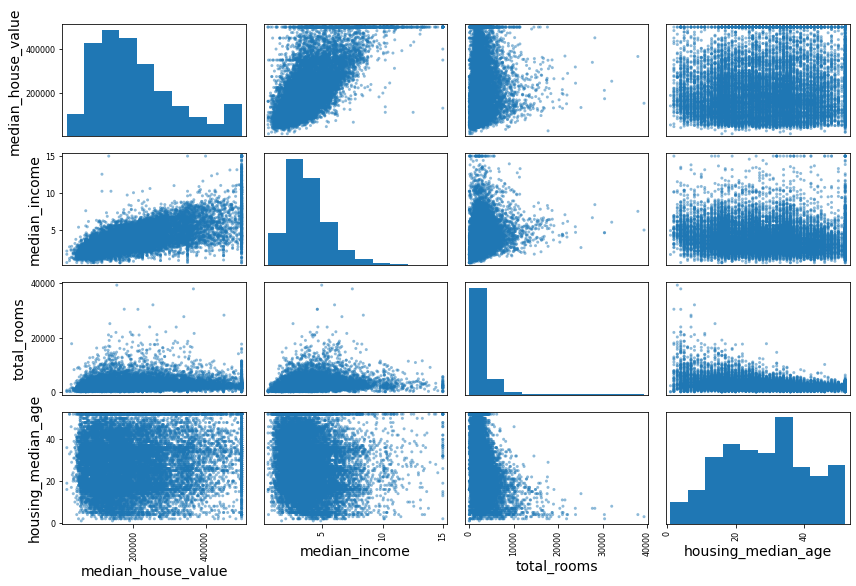

In [33]:
#Option #2 - scatter_matrix() function from Pandas
#Plots every numerical attributes with other numerical attributes

#Pick attributes that are most correlated with median housing value
attributes = ["median_house_value", "median_income", "total_rooms",
                    "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12,8))
save_fig("Scatter Matrix Plot")
print("Figure 2-15")

Saving figure Income VS House Value Scatter Plot
Figure 2-16


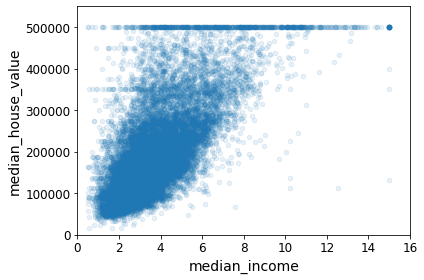

In [34]:
#The most promising attribute to predict median house value is median income, so
#let's have a closer look
housing.plot(kind="scatter", x="median_income", y="median_house_value", alpha=0.1)
plt.axis([0, 16, 0, 550000])
save_fig("Income VS House Value Scatter Plot")
print("Figure 2-16")

##### From the plot above, we can see that the correlation is very strong, an upward trend with very little dispersed points. Also, their are horizontal lines that are considered data quirks. It's best to remove those districts to prevent the algorithms from learning to reproduce them

### Experimenting with attribute combinations

In [35]:
#Let's extract new attributes from combining existing attributes that can help 
#us gain further insight
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"] = housing["population"]/housing["households"]

corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687160
rooms_per_household         0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
bedrooms_per_room          -0.259984
Name: median_house_value, dtype: float64

##### As we can see, bedrooms per room is more correlated than total numbers of rooms and bedrooms -> houses with lower bedroom/room ratio are more expensive. Also, the number of rooms per household tells us -> the larger the house, the more expensive

# End of section: Discover And Visualize The Data To Gain Insights

# Section: Prepare The Data For Machine Learning Algorithms

In [36]:
#Create a new clean copy of the training set and separate the predictors from
#the labels
housing = strat_train_set.drop("median_house_value", axis=1) #drop() labels from
#the training set
housing_labels = strat_train_set["median_house_value"].copy()

### Data cleaning

In [37]:
#Let's have a look at attributes that are missing some values
sample_incomplete_rows = housing[housing.isnull().any(axis=1)].head()
sample_incomplete_rows

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
4629,-118.30,34.07,18.0,3759.0,NaN,3296.0,1462.0,2.2708,<1H OCEAN
6068,-117.86,34.01,16.0,4632.0,NaN,3038.0,727.0,5.1762,<1H OCEAN
17923,-121.97,37.35,30.0,1955.0,NaN,999.0,386.0,4.6328,<1H OCEAN
13656,-117.30,34.05,6.0,2155.0,NaN,1039.0,391.0,1.6675,INLAND
19252,-122.79,38.48,7.0,6837.0,NaN,3468.0,1405.0,3.1662,<1H OCEAN


##### Seems like total_bedrooms are missing some values

In [38]:
#Option #1 - Git rid of the corresponding districts
sample_incomplete_rows.dropna(subset=["total_bedrooms"])

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity


In [39]:
#Option #2 - Git rid of the whole attribute
sample_incomplete_rows.drop("total_bedrooms", axis=1)

,longitude,latitude,housing_median_age,total_rooms,population,households,median_income,ocean_proximity
4629,-118.30,34.07,18.0,3759.0,3296.0,1462.0,2.2708,<1H OCEAN
6068,-117.86,34.01,16.0,4632.0,3038.0,727.0,5.1762,<1H OCEAN
17923,-121.97,37.35,30.0,1955.0,999.0,386.0,4.6328,<1H OCEAN
13656,-117.30,34.05,6.0,2155.0,1039.0,391.0,1.6675,INLAND
19252,-122.79,38.48,7.0,6837.0,3468.0,1405.0,3.1662,<1H OCEAN


In [40]:
#Option #3 - Set the missing values to some value (zero, mean, median, etc)
#Using this options requires you to replace the relevant values in the test set
#and once your system goes live
median = housing["total_bedrooms"].median()
sample_incomplete_rows["total_bedrooms"].fillna(median, inplace=True)

In [41]:
sample_incomplete_rows

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
4629,-118.30,34.07,18.0,3759.0,433.0,3296.0,1462.0,2.2708,<1H OCEAN
6068,-117.86,34.01,16.0,4632.0,433.0,3038.0,727.0,5.1762,<1H OCEAN
17923,-121.97,37.35,30.0,1955.0,433.0,999.0,386.0,4.6328,<1H OCEAN
13656,-117.30,34.05,6.0,2155.0,433.0,1039.0,391.0,1.6675,INLAND
19252,-122.79,38.48,7.0,6837.0,433.0,3468.0,1405.0,3.1662,<1H OCEAN


In [42]:
#Option #4 - Use Scikit learn's SimpleImputer
imputer = SimpleImputer(strategy="median")

#Remove "ocean_proximity" attribute because its a text and the median can only be
#calculated with numerical values
housing_num = housing.drop(["ocean_proximity"], axis=1)

imputer.fit(housing_num)

SimpleImputer(strategy='median')

In [43]:
#The imputer calculated the median for each attribute, this is useful because we
#can use the median to replace any missing values in the future
imputer.statistics_

array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
        408.    ,    3.5409])

In [44]:
#Check if the values are the same when computing manually
housing_num.median().values

array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
        408.    ,    3.5409])

In [45]:
#Transform the training set so that the missing values are replaced with the 
#median
X = imputer.transform(housing_num)

In [46]:
#The result is a numpy array containing the transformed features. Let's convert
#it back to a pandas DataFrame
housing_tr = pd.DataFrame(X, columns=housing_num.columns,
                             index=housing_num.index)

In [47]:
#The converted DataFrame
housing_tr.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
17606,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042
18632,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214
14650,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621
3230,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839
3555,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347


In [48]:
#The location of previously missing values
housing_tr.loc[sample_incomplete_rows.index.values]

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
4629,-118.30,34.07,18.0,3759.0,433.0,3296.0,1462.0,2.2708
6068,-117.86,34.01,16.0,4632.0,433.0,3038.0,727.0,5.1762
17923,-121.97,37.35,30.0,1955.0,433.0,999.0,386.0,4.6328
13656,-117.30,34.05,6.0,2155.0,433.0,1039.0,391.0,1.6675
19252,-122.79,38.48,7.0,6837.0,433.0,3468.0,1405.0,3.1662


### Handling text and categorical attributes

In [49]:
#Preprocess of categorical attribute "ocean_proximity"
#Option #1 - Using OrdinalEncoder
housing_cat = housing[["ocean_proximity"]]
housing_cat.head(10)

,ocean_proximity
17606,<1H OCEAN
18632,<1H OCEAN
14650,NEAR OCEAN
3230,INLAND
3555,<1H OCEAN
19480,INLAND
8879,<1H OCEAN
13685,INLAND
4937,<1H OCEAN
4861,<1H OCEAN


In [50]:
#Convert text attribute to number with Scikit Learn's OrdinalEncoder
ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)

#The values correspond to the index position of the categories: 0.="<1H OCEAN",
#1.="INLAND", 2.="ISLAND" etc
housing_cat_encoded[:10]

array([[0.],
       [0.],
       [4.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.]])

In [51]:
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

##### Ordinal Encoder is less appropriate in our case because the ML algorithm will assume that the two nearby values are more similar than the two distant values. Ex: "bad", "average", "good", "excellent".

In [52]:
#Option #2 - Use Scikit Learn's OneHotEncoder
#We use 1 to encode the correct category(1) and 0 for the rest
#Note: If a categorical attribute has a large number of categories, it will slow
#down training and degrade performance.
cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

In [53]:
#OneHotEncoder returns a sparse matrix, only storing the location of nonzero 
#elements.
#If you want, convert the sparse matrix into a dense array
#or add sparse=False -> OneHotEndocer(sparse=False)
housing_cat_1hot.toarray()

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

In [54]:
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

### Custom transformer

In [55]:
#Create a custom transformer to add extra attributes. This is another way in 
#which we can add:"rooms_per_household", "bedrooms_per_room", "population_per_household"

#Implement a class with three methods: fit(), transform(), fit_transfrom()
#TransformerMixin gives you the therd method
#BaseEstimator (avoid adding: *args, **kargs) gives you 2 methods: 
#get_params(), set_params(), useful fro automatic hyperparameter tuning

#Get column indices dynamically
col_names = "total_rooms", "total_bedrooms", "population", "households"
rooms_ix, bedrooms_ix, population_ix, households_ix = [
    housing.columns.get_loc(c) for c in col_names]

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room=True): #No *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self #Nothing else to do
    def transform(self, X):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,
                        bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]
        
attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)#

In [56]:
#housing_extra_attribs is a numpy array, so we've lost the column names (that's
#a problem with Scikit Learn). Let's recover the DataFrame with Pandas
print(type(housing_extra_attribs))

#pd.DataFrame(data=None, index=None, columns=None, dtype=None, copy=False)
#Returns a two dimensional, size mutable, potentionally hetrogeneous tabular data
housing_extra_attribs = pd.DataFrame(
    housing_extra_attribs,
    index=housing.index,
    columns=list(housing.columns)+["rooms_per_household", "population_per_household"])
housing_extra_attribs.head()

<class 'numpy.ndarray'>


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,rooms_per_household,population_per_household
17606,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042,<1H OCEAN,4.625369,2.094395
18632,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214,<1H OCEAN,6.00885,2.707965
14650,-117.2,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621,NEAR OCEAN,4.225108,2.025974
3230,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839,INLAND,5.232295,4.135977
3555,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347,<1H OCEAN,4.50581,3.047847


### Feature scaling

##### ML algorithms don't perform well when the numerical values are of different scale. There are two common ways to get them at the same scale:

##### Min-max scaling(normalization) - Values are shifted and rescaled so that they end up ranging from 0 to 1

<img src="images/min_max_scaling.png" style="width: 250px; margin-left:0;">

##### Standardization(z-score normalization) - Values aren't bound to a specific range, it can be a problem for a neural network that often expects an input ranging from 0 to 1, and is much less affected by outliers

<img src="images/standardization_scaling.png" style="width:250px; margin-left:0;)">

### Transformation pipelines

In [57]:
#Let's build a pipeline for preprocessing the numerical attributes

#sklearn.pipeline.Pipeline(steps, *, memory=None, verbose=False)
#Sequnetially applies a list of transforms and a final estimator
num_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("attribs_adder", CombinedAttributesAdder()),
    ("std_scaler", StandardScaler())
])

housing_num_tr = num_pipeline.fit_transform(housing_num)

In [58]:
housing_num_tr #numpy array

array([[-1.15604281,  0.77194962,  0.74333089, ..., -0.31205452,
        -0.08649871,  0.15531753],
       [-1.17602483,  0.6596948 , -1.1653172 , ...,  0.21768338,
        -0.03353391, -0.83628902],
       [ 1.18684903, -1.34218285,  0.18664186, ..., -0.46531516,
        -0.09240499,  0.4222004 ],
       ...,
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.3469342 ,
        -0.03055414, -0.52177644],
       [ 0.78221312, -0.85106801,  0.18664186, ...,  0.02499488,
         0.06150916, -0.30340741],
       [-1.43579109,  0.99645926,  1.85670895, ..., -0.22852947,
        -0.09586294,  0.10180567]])

##### Up until now we have been dealing with numerical and categorical columns separately. Scikit Learn's ColumnTransformer can do both

In [59]:
#sklearn.compose.ColumnTransformer(transformer, *, remainder="drop", 
#sparse_threshold=0.3, n_jobs=None, transformer_weights=None, verbose=False)
#Applies transformers to columns of an arrays or pandas DataFrame
num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
    #a list of tupples, each tupple: 
    #name, transformer, list of names of columns to apply transformation
    ("num", num_pipeline, num_attribs),
    ("cat", OneHotEncoder(), cat_attribs)
])

housing_prepared = full_pipeline.fit_transform(housing)

In [60]:
housing_prepared.shape

(16512, 16)

# End Of Section: Prepare The Data For Machine Learning Algorithms

# Section: Select And Train A Model

### Training and evaluation on the training set

In [65]:
#Linear Regression Model
lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression()

In [66]:
#Let's try it on a few examples from the training set
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)

print("Predictions:", lin_reg.predict(some_data_prepared))

Predictions: [210644.60459286 317768.80697211 210956.43331178  59218.98886849
 189747.55849879]


In [ ]:
#Compare against the actual values
print("Labels:", list(some_labels))

##### The first prediction is off by 26.5%(difference of 75,956). Let's measure the model's RMSE and MAEon the whole training set  to see if the model is underfitting

In [ ]:
#sklearn.metrics.mean_squared_error(y_true, y_pred, *, sample_weight=None, 
#multioutput="uniform_average", squared=True)
#Returns the mean squared error regression loss
housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)

#numpy.sqrt(x, /, out=None, *, where=True, casting="same_kind", order="K",
#dtype=None, subok=True[, signature, extobj])
#Returns the non negative square root of an array, element wise
lin_rmse = np.sqrt(lin_mse)
lin_rmse

In [ ]:
#sklearn.metrics.mean_absolute_error(y_true, y_pred, *, sample_weight=None,
#multioutput="uniform_average")
#Returns the mean absolute error regression loss
lin_mae = mean_absolute_error(housing_labels, housing_predictions)
lin_mae

In [ ]:
#let's checkout a different model - Decision Tree Model
#sklearn.tree.DecisionTreeRegressor(*, criterion="mse", splitter="best",
#max_depth=None, min_samples_split=2, min_samples_leaf=1, mean_weight_fraction_leaf=0.0,
#max_features=None, random_state=None, max_leaf_nodes=None, 
#min_impurity_decrease=0.0, min_impurity_split=None, ccp_alpha=0.0)
#Returns a decision tree regressor
tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(housing_prepared, housing_labels)

In [ ]:
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

##### The decision tree regressor is overfitting the training set, the loss indicates 0. We need more insight, thus we need to validate our model on a portion of the training set

### Better evaluation using cross validation

In [ ]:
#We will use Scikit Learn's K fold cross validation feature.
#sklearn.model_selection.cross_val.score(estimator, X, y=None, *, groups=None,
#scoring=None, cv=None, n_jobs=None, verbose=0, fit_params=None, 
#pre_dispatch="2*n_jobs", error_score=nan)
#Evaluate a score by cross validation

#The following splits the training set into 10 subsets(folds), trains and 
#evaluates the model 10 times, picking a different fold each time
scores = cross_val_score(tree_reg, housing_prepared, housing_labels, 
                        scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores) #Scoring functionality is that of a utility
#function. That's why there is a "-" before the scores

In [ ]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard Deviation:", scores.std())
display_scores(tree_rmse_scores)

In [ ]:
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels, 
                             scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

In [ ]:
#sklearn.ensemble.RandomForestRegressor(n_estimators=100, *, criterion="mse", 
#max_depth=None, min_samples_split=2, min_samples_leaf=1, 
#mean_weight_fraction_leaf=0.0, max_features=auto, random_state=None, 
#max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, 
#ccp_alpha=0.0, bootstrap=True, oob_score=False, n_jobs=None, verbose=0,
#warm_start=False, max_samples=None)
#Returns a random tree regressor

forest_reg = RandomForestRegressor(n_estimators=100, random_state=42)
forest_reg.fit(housing_prepared, housing_labels)

In [ ]:
housing_predictions = forest_reg.predict(housing_prepared)
forest_mse = mean_squared_error(housing_labels, housing_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

In [ ]:
forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels,
                               scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

In [ ]:
#sklearn.svm.SVR(*, kernel="rbf", degree=3, gamma="scale", coef0=0.0, tol=0.001,
#C=1.0, epsilon=0.1, shrinking=True, cache_size=200, verbose=False, max_iter=-1)
svm_reg = SVR(kernel="linear")
svm_reg.fit(housing_prepared, housing_labels)
housing_predictions = svm_reg.predict(housing_prepared)
svm_mse = mean_squared_error(housing_labels, housing_predictions)
svm_rmse = np.sqrt(svm_mse)
svm_rmse

# End Of Section: Select And Train A Model

# Section: Fine Tune Your Model

### Grid search

In [ ]:
#Scikit Learn's GridSearchCV uses cross validation to find combinations of
#hyperparameters 
#sklearn.model_selection.GridSearchCV(estimator, param_grid, *, scoring=None, 
#n_jobs=None, refit=True, cv=None, verbose=0, pre_dispatch="2*n_jobs",
#error_score=nan, return_train_score=False)
#Exhaustive search over specified parameter values for an estimator

param_grid = [
    #12 (3x4) combinations of hyperparameters
    {"n_estimators":[3, 10, 30], "max_features":[2, 4, 6, 8]},
    #6 (2x3) combinations of hyperparameters
    {"bootstrap":[False], "n_estimators":[3, 10], "max_features":[2, 3, 4]}
]
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                          scoring="neg_mean_squared_error",
                          return_train_score=True)
grid_search.fit(housing_prepared, housing_labels)

In [ ]:
#Best combination 
grid_search.best_params_

In [ ]:
#Best estimator
grid_search.best_estimator_

##### Scores of each hyperparameter combination

In [ ]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

In [ ]:
#Uncomment to see more information about cvres (18 rows x 23 columns)
#pd.DataFrame(cvres) 

### Randomized search

##### Best to use the hyperparameter search space is large. You can set the amount of iterations you want thus having more control on computing budget

In [ ]:
#sklearn.model_selection.RandomizedSearchCV(estimator, param_distributions, *,
#n_iter=10, scoring=None, n_jobs=None, refit=True, cv=None, verbose=0, 
#pre_dispatch="2*n_jobs", random_state=None, error_score=nan, 
#return_train_score=False)
#Randomized search on hyperparameters

In [ ]:
params_distrib = {
    "n_estimators":randint(low=1, high=200),
    "max_features":randint(low=1, high=8),
}
rnd_search = RandomizedSearchCV(forest_reg, param_distributions=params_distrib,
                                    n_iter=10, cv=5,
                                    scoring="neg_mean_squared_error", 
                                    random_state=42)
rnd_search.fit(housing_prepared, housing_labels)

In [ ]:
cvres = rnd_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

In [ ]:
#Best combination
rnd_search.best_params_

In [ ]:
#Best estimator
rnd_search.best_estimator_

### Analyze the best models and their errors

##### Let's see if we can gain some insights from the RandomForestRegressor about the importance of each attribute for making accurate predictions

In [ ]:
feature_importances = rnd_search.best_estimator_.feature_importances_
feature_importances

##### Let's display the results next to their corresponding attribute names

In [ ]:
extra_attribs = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"]
cat_encoder = full_pipeline.named_transformers_["cat"] #access the fitted transformer by name
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse=True)

##### As we can see, from the "ocean_proximity" category there is only one useful feature: "INLAND". Thus, we can drop the other features

### Evaluate your system on the test set

In [ ]:
final_model = grid_search.best_estimator_

X_test = strat_test_set.drop("median_house_value", axis=1)#drop() makes a copy
y_test = strat_test_set["median_house_value"].copy()

X_test_prepared = full_pipeline.transform(X_test)#Dont do fit_transform, you 
#don't want to fit the test set
final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)

In [ ]:
final_rmse

##### Calculating the confidence interval will help us make a decision of whether or not to launch our model to production. We will be using a 95% confidence interval, and see if our predictions fall in between those estimates

In [ ]:
confidence = 0.95
squared_errors = (final_predictions - y_test)**2
np.sqrt(stats.t.interval(confidence, len(squared_errors)-1,
                        loc=squared_errors.mean(),
                        scale=stats.sem(squared_errors)))

# End Of Section: Fine Tune Your Model

# Section: Extra Material

### A full pipeline with both preparation and prediction

In [67]:
full_pipeline_with_predictor = Pipeline([
        ("preparation", full_pipeline),
        ("linear", LinearRegression())
    ])
full_pipeline_with_predictor.fit(housing, housing_labels)
full_pipeline_with_predictor.predict(some_data)

array([210644.60459286, 317768.80697211, 210956.43331178,  59218.98886849,
       189747.55849879])

### Model persistence using joblib

In [74]:
#The joblib library allows us to save our model and easily load it in order to 
#compare with other models
my_model = full_pipeline_with_predictor
joblib.dump(my_model, "my_model.pkl")

#When you want to load
my_model_loaded = joblib.load("my_model.pkl")
result = my_model_loaded.predict(some_data)
print(result)

[210644.60459286 317768.80697211 210956.43331178  59218.98886849
 189747.55849879]
